In [1]:
import cv2
import numpy as np
import pickle
import matplotlib.pyplot as plt

from inception_resnet_v1 import InceptionResNetV1
from Generator import DataGenerator

import tensorflow as tf

from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras.callbacks import *

Using TensorFlow backend.


# Define model

In [2]:
input_shape = (120,120,3)

feature_model = InceptionResNetV1(input_shape=input_shape)
feature_model.summary()

x1 = Input(input_shape)
x2 = Input(input_shape)
x3 = Input(input_shape)

v1 = feature_model(x1)
v2 = feature_model(x2)
v3 = feature_model(x3)

p = Subtract()([v1, v2])
n = Subtract()([v1, v3])

euclidean_distance = Lambda(lambda x: K.sqrt(K.sum(K.square(x), axis=-1, keepdims=True)))
d_p = euclidean_distance(p)
d_n = euclidean_distance(n)
d = Concatenate(axis=-1)([d_p, d_n])

model = Model([x1, x2, x3], d)
model.summary()

Model: "inception_resnet_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 120, 120, 3)  0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 59, 59, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 59, 59, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 59, 59, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
________________________________________________________________________________

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 120, 120, 3)  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 120, 120, 3)  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 120, 120, 3)  0                                            
__________________________________________________________________________________________________
inception_resnet_v1 (Model)     (None, 128)          22808144    input_2[0][0]                    
                                                                 input_3[0][0]              

# Load data for test

In [2]:
import glob
import os

data_path = '../data/mask/face dataset/*'
data_dir_paths = glob.glob(data_path)

index = [0]
count = []
images = []
for dir_path in data_dir_paths:
    image_paths = glob.glob(os.path.join(dir_path,'*'))
    index.append(len(image_paths) + index[-1])
    count.append(len(image_paths))
    
    for image_path in image_paths:
        image = cv2.imread(image_path)
        images.append(image)
del index[-1]
images = np.array(images)
index = np.array(index)
count = np.array(count)

print(images.shape)
print(index.shape)
print(count.shape)

(300, 120, 120, 3)
(50,)
(50,)


# Load data for train

In [3]:
gen_train = DataGenerator(data_path='../data/db_cropped_face/data.h5', data_type='train', batch_size=100)
gen_val = DataGenerator(data_path='../data/db_cropped_face/data.h5', data_type='val', batch_size=100)

C:\Users\HP_2\anaconda3\envs\hhs\lib\site-packages\keras\utils\io_utils.py:60: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(datapath)


# Train

In [4]:
def triplet_loss(y_true, y_pred):
    margin = 0.2
    loss = K.mean(K.maximum(0.0, K.square(y_pred[:, 0]) - K.square(y_pred[:, 1]) + margin))
    return loss

def lr_schedule(epoch):
    lr = 0.001
    if epoch > 20: lr /= 10
    if epoch > 40: lr /= 10
    if epoch > 60: lr /= 10
    if epoch > 80: lr /= 10
    if epoch > 100: lr /= 10
    return lr

scheduler = LearningRateScheduler(lr_schedule)
check_point = ModelCheckpoint(filepath='check_point(best).h5', verbose=1, save_best_only=True, mode='min')
callbacks = [scheduler, check_point]

model.compile(optimizer=RMSprop(lr=0.001), loss=triplet_loss)
history = model.fit_generator(generator=gen_train, epochs=120, validation_data=gen_val, callbacks=callbacks)

model.save('model.h5', include_optimizer=False)
with open(hist_path, 'wb') as file:
    pickle.dump(history.history, file)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

Epoch 1/120
1914/1914 [==============================] - 1187s 620ms/step - loss: 0.0353 - val_loss: 0.0207

Epoch 00001: val_loss improved from inf to 0.02068, saving model to check_point(best).h5
Epoch 2/120
1914/1914 [==============================] - 1144s 598ms/step - loss: 0.0092 - val_loss: 0.0248

Epoch 00002: val_loss did not improve from 0.02068
Epoch 3/120
1914/1914 [==============================] - 1139s 595ms/step - loss: 0.0062 - val_loss: 0.0268

Epoch 00003: val_loss did not improve from 0.02068
Epoch 4/120
1914/1914 [==============================] - 1141s 596ms/step - loss: 0.0048 - val_loss: 0.0330

Epoch 00004: val_loss did not improve from 0.02068
Epoch 5/120
1914/1914 [==============================] - 1140s 595ms/step - loss: 0.0034 - val_loss: 0.0220

Epoch 00005: val_loss did not improve from 0.02068
Epoch 6/120
1914/1914 [==============================] - 1139s 595ms/step - loss: 0.0026 - val_loss: 0.0348

Epoch 00006: val_loss did not improve from 0.02068
Ep

1914/1914 [==============================] - 1146s 599ms/step - loss: 1.6217e-04 - val_loss: 0.0076

Epoch 00099: val_loss did not improve from 0.00218
Epoch 100/120
1914/1914 [==============================] - 1146s 599ms/step - loss: 1.3726e-04 - val_loss: 0.0082

Epoch 00100: val_loss did not improve from 0.00218
Epoch 101/120
1914/1914 [==============================] - 1146s 599ms/step - loss: 1.4127e-04 - val_loss: 0.0117

Epoch 00101: val_loss did not improve from 0.00218
Epoch 102/120
1914/1914 [==============================] - 1147s 599ms/step - loss: 1.4440e-04 - val_loss: 0.0150

Epoch 00102: val_loss did not improve from 0.00218
Epoch 103/120
1914/1914 [==============================] - 1146s 599ms/step - loss: 1.3106e-04 - val_loss: 0.0248

Epoch 00103: val_loss did not improve from 0.00218
Epoch 104/120
1914/1914 [==============================] - 1146s 599ms/step - loss: 1.4718e-04 - val_loss: 0.0083

Epoch 00104: val_loss did not improve from 0.00218
Epoch 105/120
1914

NameError: name 'hist_path' is not defined

# Show and save history

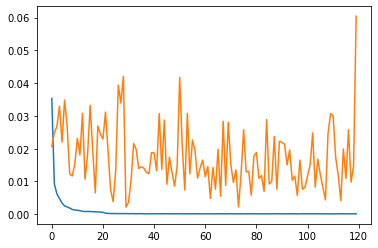

In [6]:
with open('hist', 'wb') as file:
    pickle.dump(history.history, file)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

# Load model and generator

In [6]:
model = load_model('../result/model/model.h5', compile=False, custom_objects={'tf': tf})
model.summary()

# gen_test = DataGenerator(data_path='../data/db_cropped_face/data.h5', data_type='test', batch_size=2663)
gen_test = DataGenerator(images, index, count, batch_size=50)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 120, 120, 3)  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 120, 120, 3)  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 120, 120, 3)  0                                            
__________________________________________________________________________________________________
inception_resnet_v1 (Model)     (None, 128)          22808144    input_2[0][0]                    
                                                                 input_3[0][0]              

# Test

In [21]:
genuine_pair = []
imposter_pair = []
for i in range(gen_test.__len__()):
    print('%dth / %d'%(i, gen_test.__len__()))
    xs, _ = gen_test.__getitem__(i)
    pred = model.predict(xs)
    genuine_pair.append(pred[:, 0])
    imposter_pair.append(pred[:, 1])
genuine_pair = np.array(genuine_pair).flatten()
imposter_pair = np.array(imposter_pair).flatten()
np.save('mask_genuine', genuine_pair)
np.save('mask_imposter', imposter_pair)

print(genuine_pair.shape)
print(imposter_pair.shape)
print(genuine_pair.min(), genuine_pair.max())
print(imposter_pair.min(), imposter_pair.max())

0th / 15
1th / 15
2th / 15
3th / 15
4th / 15
5th / 15
6th / 15
7th / 15
8th / 15
9th / 15
10th / 15
11th / 15
12th / 15
13th / 15
14th / 15
(750,)
(750,)
0.008207713 1.614831
0.030854976 1.7296044


In [22]:
max_f1_score = 0
max_accuracy = 0
for threshold in np.arange(0, 2, 0.001):
    tp = np.sum(genuine_pair < threshold)
    fp = np.sum(imposter_pair < threshold)
    fn = np.sum(genuine_pair >= threshold)
    tn = np.sum(imposter_pair >= threshold)
    
    if tp == 0:
        precision = 0
        recall = 0
        f1_score = 0
    else:
        precision = tp / (tp+fp)
        recall = tp / (tp+fn)
        f1_score = 2 * (precision * recall) / (precision + recall)
    accuracy = (tp + tn) / (tp + fn + fp + tn)
    
    if f1_score > max_f1_score:
        max_f1_score = f1_score
    if accuracy > max_accuracy:
        max_accuracy = accuracy
        
print('F1 score : ', max_f1_score)
print('Accuracy : ', max_accuracy)

F1 score :  0.7023230686115612
Accuracy :  0.6546666666666666


# Genuine imposter histogram

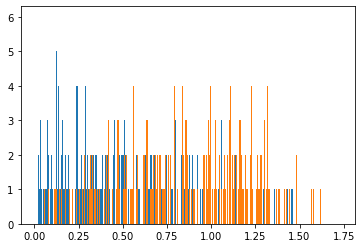

In [23]:
plt.hist(genuine_pair, bins=1000)
plt.hist(imposter_pair, bins=1000)
plt.show()